# Classification Sarkasme using RNN
## Importing libraries

In [ ]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from collections import Counter
import numpy as np
import re


## Load Dataset & Preprocessing

In [ ]:
import pandas as pd

# Load JSON (pastikan sudah diunduh ke Colab atau gunakan raw GitHub URL)
df = pd.read_json("https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json", lines=True)

# Ambil text & label
texts = df['headline'].values
labels = df['is_sarcastic'].values



In [ ]:
# Preprocessing sederhana
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

texts = [clean_text(t) for t in texts]



In [ ]:
# Tokenisasi manual
all_words = ' '.join(texts).split()
word_counts = Counter(all_words)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(w, vocab['<UNK>']) for w in text.split()]

encoded_texts = [encode(t) for t in texts]
max_len = 20  # batasi panjang input

def pad(seq, max_len):
    return seq[:max_len] + [0]*(max_len - len(seq))

padded_texts = [pad(seq, max_len) for seq in encoded_texts]

X = torch.tensor(padded_texts)
y = torch.tensor(labels)

## DataLoader & Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class SarcasmDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SarcasmDataset(X_train, y_train)
test_ds = SarcasmDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


## RNN Model


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))
        return out

model = RNNModel(len(vocab), embed_dim=64, hidden_dim=64)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


##Training Loop dan Simpan Akurasi & Loss

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(10):
    model.train()
    total_loss, total_acc = 0, 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(output) > 0.5).int()
        total_acc += (preds == y_batch).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_acc / len(train_ds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Eval
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch).squeeze()
            loss = criterion(output, y_batch.float())
            test_loss += loss.item()
            preds = (torch.sigmoid(output) > 0.5).int()
            test_acc += (preds == y_batch).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_ds)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")


Epoch 1 | Train Loss: 0.0225 | Train Acc: 99.49% | Test Loss: 0.8028 | Test Acc: 82.44%
Epoch 2 | Train Loss: 0.0180 | Train Acc: 99.60% | Test Loss: 0.7849 | Test Acc: 82.78%
Epoch 3 | Train Loss: 0.0187 | Train Acc: 99.47% | Test Loss: 0.9263 | Test Acc: 82.65%
Epoch 4 | Train Loss: 0.0148 | Train Acc: 99.63% | Test Loss: 0.8810 | Test Acc: 82.52%
Epoch 5 | Train Loss: 0.0107 | Train Acc: 99.75% | Test Loss: 1.0027 | Test Acc: 82.44%
Epoch 6 | Train Loss: 0.0086 | Train Acc: 99.80% | Test Loss: 0.9073 | Test Acc: 82.82%
Epoch 7 | Train Loss: 0.0137 | Train Acc: 99.65% | Test Loss: 0.9461 | Test Acc: 82.53%
Epoch 8 | Train Loss: 0.0073 | Train Acc: 99.86% | Test Loss: 1.0565 | Test Acc: 82.67%
Epoch 9 | Train Loss: 0.0081 | Train Acc: 99.78% | Test Loss: 1.0275 | Test Acc: 81.54%
Epoch 10 | Train Loss: 0.0094 | Train Acc: 99.77% | Test Loss: 0.9925 | Test Acc: 82.50%


## Evaluasi Metrik

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC Curve & Evaluasi
model.eval()
y_pred, y_true, y_scores = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = torch.sigmoid(model(X_batch).squeeze())
        preds = (output > 0.5).int()
        y_pred.extend(preds.tolist())
        y_true.extend(y_batch.tolist())
        y_scores.extend(output.tolist())

# Skor Evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_scores)

print(f"Akurasi: {acc:.2f}")
print(f"Presisi: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")
# Akurasi Training dan Testing (dalam persen)
train_acc_percent = train_accuracies[-1] * 100
test_acc_percent = test_accuracies[-1] * 100

print(f"Akurasi Training: {train_acc_percent:.2f}%")
print(f"Akurasi Testing: {test_acc_percent:.2f}%")


Akurasi: 0.82
Presisi: 0.82
Recall: 0.78
F1-Score: 0.80
AUC: 0.89
Akurasi Training: 99.77%
Akurasi Testing: 82.50%


## Visualisasi Loss, Akurasi

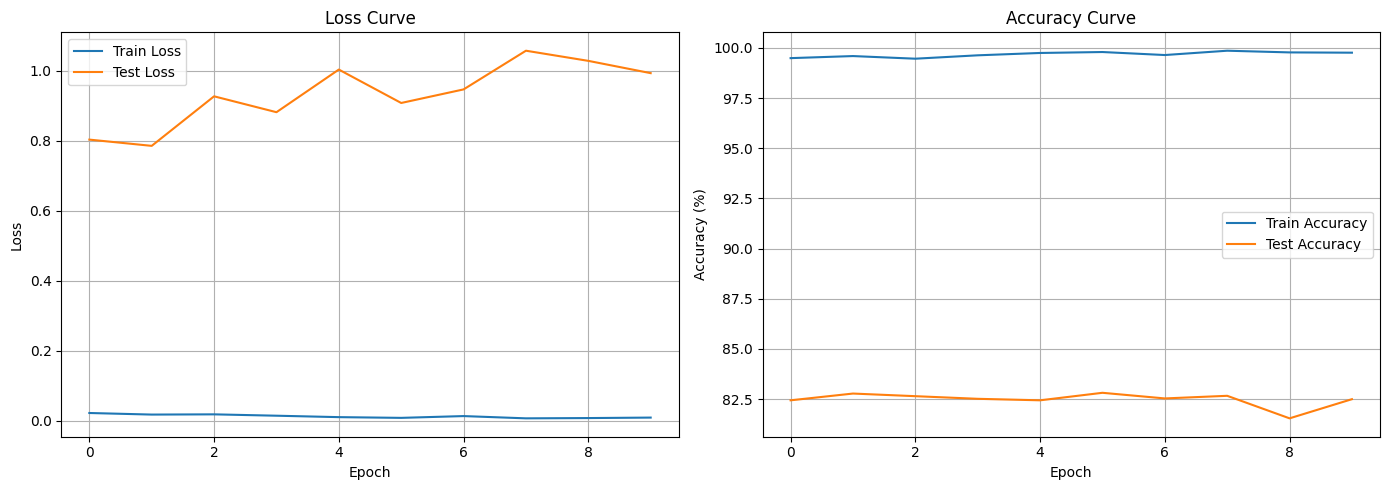

In [ ]:
plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot([acc * 100 for acc in train_accuracies], label='Train Accuracy')
plt.plot([acc * 100 for acc in test_accuracies], label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



## Visualisasi ROC

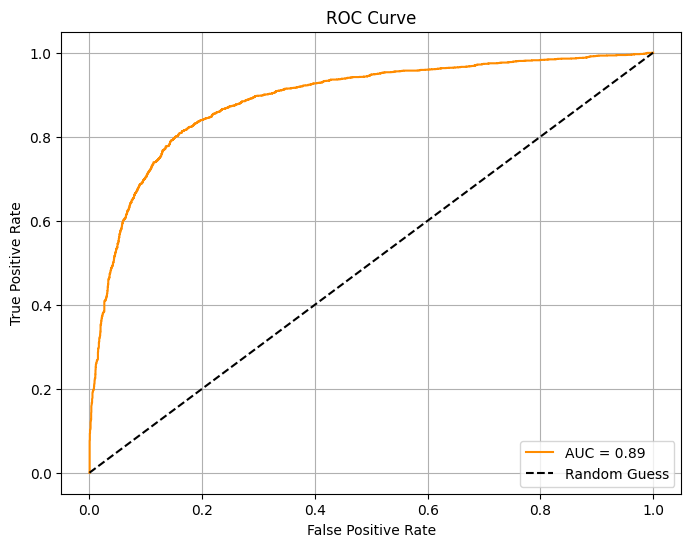

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Confusion Matrix

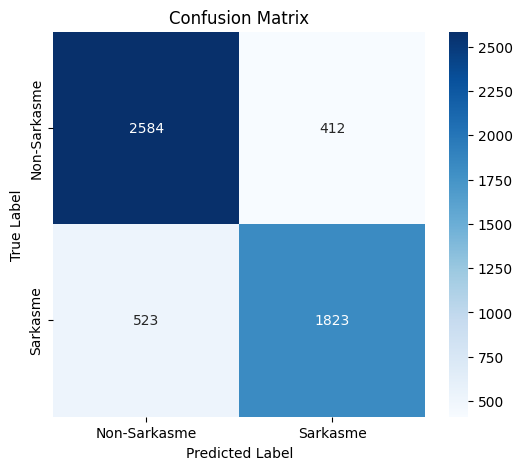

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sarkasme', 'Sarkasme'], yticklabels=['Non-Sarkasme', 'Sarkasme'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
